## Install TensorTrade

In [1]:
!python3 -m pip install git+https://github.com/abstractguy/tensortrade.git

  Cloning https://github.com/abstractguy/tensortrade.git to /tmp/pip-req-build-n00ptfml
  Running command git clone --filter=blob:none --quiet https://github.com/abstractguy/tensortrade.git /tmp/pip-req-build-n00ptfml
  Resolved https://github.com/abstractguy/tensortrade.git to commit ad4579d8416df3a45d0f93aaa66462f6353b091b
  Preparing metadata (setup.py) ... done


In [2]:
!pip install tensorflow_probability==0.15.0 opencv-python wandb pyarrow

## Define global variables

In [3]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [4]:
from glob import glob

import os

base_path = '/usr/local/lib/python3.8/dist-packages/tensortrade/agents/'

for model_path in glob('models/*'):
    model = model_path.split('/')[1]
    from_path = model_path + '/models'
    to_path = base_path + model + '/'
    !cp -R $from_path $to_path

In [5]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [6]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.800000,8793.0,8714.9,8739.0,8988053
1,2018-05-15 07:00 AM,8739.000000,8754.8,8719.3,8743.0,2288904
2,2018-05-15 08:00 AM,8743.000000,8743.1,8653.2,8723.7,8891773
3,2018-05-15 09:00 AM,8723.700000,8737.8,8701.2,8708.1,2054868
4,2018-05-15 10:00 AM,8708.100000,8855.7,8695.8,8784.4,17309722
...,...,...,...,...,...,...
32961,2022-02-16 08:00 PM,44257.737355,44389.0,44131.0,44142.0,4496577
32962,2022-02-16 09:00 PM,44135.000000,44192.0,43933.0,44099.0,3720436
32963,2022-02-16 10:00 PM,44100.000000,44159.0,44001.0,44037.0,4400226
32964,2022-02-16 11:00 PM,44038.000000,44187.0,43885.0,43909.0,4766527


## Create features for the feed module

In [7]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.study(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [8]:
data = generate_features(data)
data

/usr/lib/python3.8/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
/usr/local/lib/python3.8/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence t

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.300000,7898.8,7849.8,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,-6.144036e+09,0.900137,5.262897e+305,0.101490,57560.000000,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.400000,7889.7,7661.0,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,-6.566837e+09,1.423601,5.262897e+305,0.101490,57560.000000,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.000000,7700.1,7548.1,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,-7.238506e+09,1.535994,5.262897e+305,0.101490,57560.000000,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.400000,7623.6,7441.8,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,-8.050434e+09,1.844482,5.262897e+305,0.101490,57560.000000,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.100000,7551.6,7403.0,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,-8.894369e+09,1.709754,5.262897e+305,0.101490,57560.000000,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32761,2022-02-16 08:00 PM,44257.737355,44389.0,44131.0,44142.0,4496577,1.026291e+10,-4288453809,-0.000532,6.794608e+08,...,-2.220338e+09,-0.701738,5.262897e+305,0.100089,58050.523526,73.333333,0.351086,0.507550,0.082143,-0.356540
32762,2022-02-16 09:00 PM,44135.000000,44192.0,43933.0,44099.0,3720436,1.026395e+10,-4292174245,0.055260,5.595409e+08,...,-2.526321e+09,-0.621083,5.262897e+305,0.100096,58050.523526,68.333333,0.249994,0.360845,0.082039,-0.357167
32763,2022-02-16 10:00 PM,44100.000000,44159.0,44001.0,44037.0,4400226,1.026156e+10,-4296574471,0.010039,4.406330e+08,...,-2.606421e+09,-0.676167,5.262897e+305,0.100087,58050.523526,58.333333,0.276203,0.398928,0.081986,-0.358071
32764,2022-02-16 11:00 PM,44038.000000,44187.0,43885.0,43909.0,4766527,1.025755e+10,-4301340998,-0.006650,2.905261e+08,...,-2.318499e+09,-0.288463,5.262897e+305,0.100119,58050.523526,45.000000,0.296065,0.427972,0.081919,-0.359936


## Remove features with low variance before splitting the dataset

In [9]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.300000,7898.8,7849.8,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,-6.144036e+09,0.900137,5.262897e+305,0.101490,57560.000000,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.400000,7889.7,7661.0,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,-6.566837e+09,1.423601,5.262897e+305,0.101490,57560.000000,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.000000,7700.1,7548.1,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,-7.238506e+09,1.535994,5.262897e+305,0.101490,57560.000000,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.400000,7623.6,7441.8,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,-8.050434e+09,1.844482,5.262897e+305,0.101490,57560.000000,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.100000,7551.6,7403.0,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,-8.894369e+09,1.709754,5.262897e+305,0.101490,57560.000000,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32761,2022-02-16 08:00 PM,44257.737355,44389.0,44131.0,44142.0,4496577,1.026291e+10,-4288453809,-0.000532,6.794608e+08,...,-2.220338e+09,-0.701738,5.262897e+305,0.100089,58050.523526,73.333333,0.351086,0.507550,0.082143,-0.356540
32762,2022-02-16 09:00 PM,44135.000000,44192.0,43933.0,44099.0,3720436,1.026395e+10,-4292174245,0.055260,5.595409e+08,...,-2.526321e+09,-0.621083,5.262897e+305,0.100096,58050.523526,68.333333,0.249994,0.360845,0.082039,-0.357167
32763,2022-02-16 10:00 PM,44100.000000,44159.0,44001.0,44037.0,4400226,1.026156e+10,-4296574471,0.010039,4.406330e+08,...,-2.606421e+09,-0.676167,5.262897e+305,0.100087,58050.523526,58.333333,0.276203,0.398928,0.081986,-0.358071
32764,2022-02-16 11:00 PM,44038.000000,44187.0,43885.0,43909.0,4766527,1.025755e+10,-4301340998,-0.006650,2.905261e+08,...,-2.318499e+09,-0.288463,5.262897e+305,0.100119,58050.523526,45.000000,0.296065,0.427972,0.081919,-0.359936


## Split dataset

In [10]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [11]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Get dataset statistics

In [12]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
count,32766,32766.000000,32766.000000,32766.000000,32766.000000,3.276600e+04,3.276600e+04,3.276600e+04,32766.000000,3.276600e+04,...,3.276600e+04,32766.000000,3.276600e+04,32766.000000,32766.000000,32766.000000,32766.000000,32766.000000,32766.000000,32766.000000
unique,32765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-11-10 11:00 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20043.448676,20151.731140,19927.925497,20044.583677,7.590784e+06,2.984994e+09,-1.759779e+09,0.035199,-2.223068e+08,...,-4.003214e+09,-0.006175,NaN,0.115180,57799.349679,53.460345,0.228193,0.627051,0.112758,-0.288476
std,NaN,18544.252337,18651.001134,18430.210898,18544.661352,1.470395e+07,3.834262e+09,1.008568e+09,0.165564,5.427355e+09,...,7.581645e+10,257.146552,NaN,0.055346,911.952975,33.658263,1.358897,2.231136,0.060027,0.161575
min,NaN,3229.800000,3247.100000,3215.200000,3229.800000,0.000000e+00,-7.758610e+08,-4.927465e+09,-0.645267,-2.669366e+11,...,-1.951553e+12,-42296.702402,5.262897e+305,0.027130,57522.000000,1.666667,-4.196721,-4.366547,0.024156,-0.686480
25%,NaN,6945.675000,6985.025000,6914.820000,6945.675000,1.197354e+06,-4.616755e+07,-2.359665e+09,-0.077192,-1.016655e+08,...,-2.057015e+09,0.251963,5.262897e+305,0.083358,57560.000000,21.666667,-0.711872,-0.954245,0.075659,-0.405164
50%,NaN,9687.900000,9724.900000,9650.320000,9688.600000,3.180811e+06,1.103612e+09,-1.589471e+09,0.033705,-2.046339e+05,...,1.785880e+06,0.970664,5.262897e+305,0.104041,57560.000000,55.000000,0.191901,0.273259,0.102202,-0.281066
75%,NaN,36015.000000,36296.000000,35699.526730,36011.500000,8.239668e+06,6.801950e+09,-1.086538e+09,0.145376,8.932448e+07,...,1.831913e+09,1.468883,5.262897e+305,0.133954,57695.000000,86.666667,1.165978,1.879242,0.132840,-0.162660


## Evaluate outlier sparsity of the data

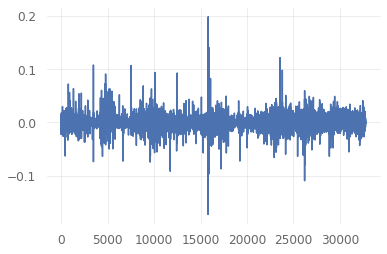

True

In [13]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

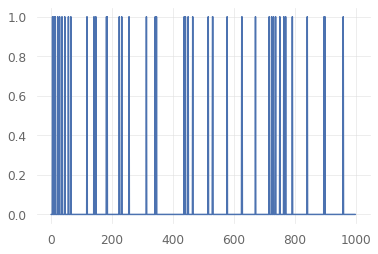

8.2%


In [14]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [15]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

0.007158196642092066

## Implement basic feature engineering

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [17]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.5)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))


KeyboardInterrupt



In [ ]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

In [ ]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [ ]:
features_to_drop = sel.features_to_drop_
features_to_drop

In [ ]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

In [ ]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

In [ ]:
X_train.columns.tolist()

## Normalize the dataset subsets to make the model converge faster

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [ ]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Write a reward scheme encouraging rare volatile upside trades

In [ ]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [ ]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## TODO: implement tuning

## Setup Trading Environment

In [ ]:
import tensortrade.env.default as default

#from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.001
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
#bitstamp_options = ExchangeOptions(commission=commission)
#bitstamp = Exchange("bitstamp", 
#                    service=execute_order, 
#                    options=bitstamp_options)(price)
bitstamp = Exchange("bitstamp", 
                    service=execute_order)(price)

cash = Wallet(bitstamp, 50000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume") 
])

action_scheme = BSH(
    cash=cash,
    asset=asset
)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=30)

#reward_scheme = SimpleProfit(window_size=30)

reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [ ]:
env.observer.feed.next()

## Setup and Train DQN Agent

In [ ]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

In [ ]:
#agent = DQNAgent(env)

#agent.train(batch_size=batch_size, 
#            n_steps=n_steps, 
#            n_episodes=n_episodes, 
#            memory_capacity=memory_capacity, 
#            save_path=save_path)

## Implement validation here

## Print basic quantstats report

In [ ]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake and default parameters are used!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

#print_quantstats_full_report(env, data)

## Using new agents

In [ ]:
max_allowed_loss = 0.90
min_periods = window_size  # Minimum of window_size

observer = default.observers.TensorTradeObserver(
    portfolio=portfolio,
    feed=feed,
    renderer_feed=renderer_feed,
    window_size=window_size,
    min_periods=min_periods
)

stopper = default.stoppers.MaxLossStopper(
    max_allowed_loss=max_allowed_loss
)

informer = default.informers.TensorTradeInformer()

renderer = default.renderers.PlotlyTradingChart()

In [ ]:
import gym
env = gym.envs.register(
    id='TradingEnv-v0',
    entry_point='tensortrade.env.generic.environment:TradingEnv',
    kwargs={
        'portfolio': portfolio,
        'action_scheme': action_scheme,
        'reward_scheme': reward_scheme,
        'observer': observer,
        'stopper': stopper,
        'informer': informer,
        'feed': feed,
        'renderer_feed': renderer_feed,
        'renderer': renderer,
        'min_periods': min_periods,
        'window_size': window_size,
    },
)

In [ ]:
from tensorflow.keras.optimizers import Adam

import tensortrade.agents as agents
from tensortrade.agents import ACER
from tensortrade.agents.utils.buffers import ReplayBuffer1
from tensortrade.agents.utils.common import ModelReader, create_envs

#envs = create_envs('TradingEnv-v0', 10, preprocess=False)
envs = [gym.make('TradingEnv-v0') for _ in range(n)]
buffers = [
    ReplayBuffer1(20000, initial_size=500, batch_size=1) for _ in range(len(envs))
]
model_cfg = agents.agents['acer']['model']['cnn'][0]
optimizer = Adam(learning_rate=7e-4)
model = ModelReader(
    model_cfg,
    output_units=[envs[0].action_space.n, envs[0].action_space.n],
    input_shape=envs[0].observation_space.shape,
    optimizer=optimizer,
).build_model()
agent = ACER(envs, model, buffers, checkpoints=['acer-trading.tf'])
agent.fit(target_reward=5000, max_steps=1000)

In [ ]:
agent.play(max_steps=1000)